In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import HfApi

env_path = os.path.join(os.getcwd(), '.env')

In [2]:
hf_token = os.getenv('HF_TOKEN)')


🚀 Démarrage de l'analyse de segmentation de vêtements

📂 Dossier analysé: /home/veron/projetInfo/modetrend/data/images/IMG

📁 Dossier de résultats: /home/veron/projetInfo/modetrend/segmentation_results

🔍 50 image(s) PNG trouvée(s)

📄 Exemples de fichiers trouvés:
  • image_0.png
  • image_1.png
  • image_10.png
  • image_11.png
  • image_12.png
  ... et 45 autre(s)


🖼️  Image 1/50: image_0.png
⏳ Envoi à l'API Hugging Face...
✅ Segmentation terminée!
✅ Résultat sauvegardé: segmentation_results/result_image_0.png


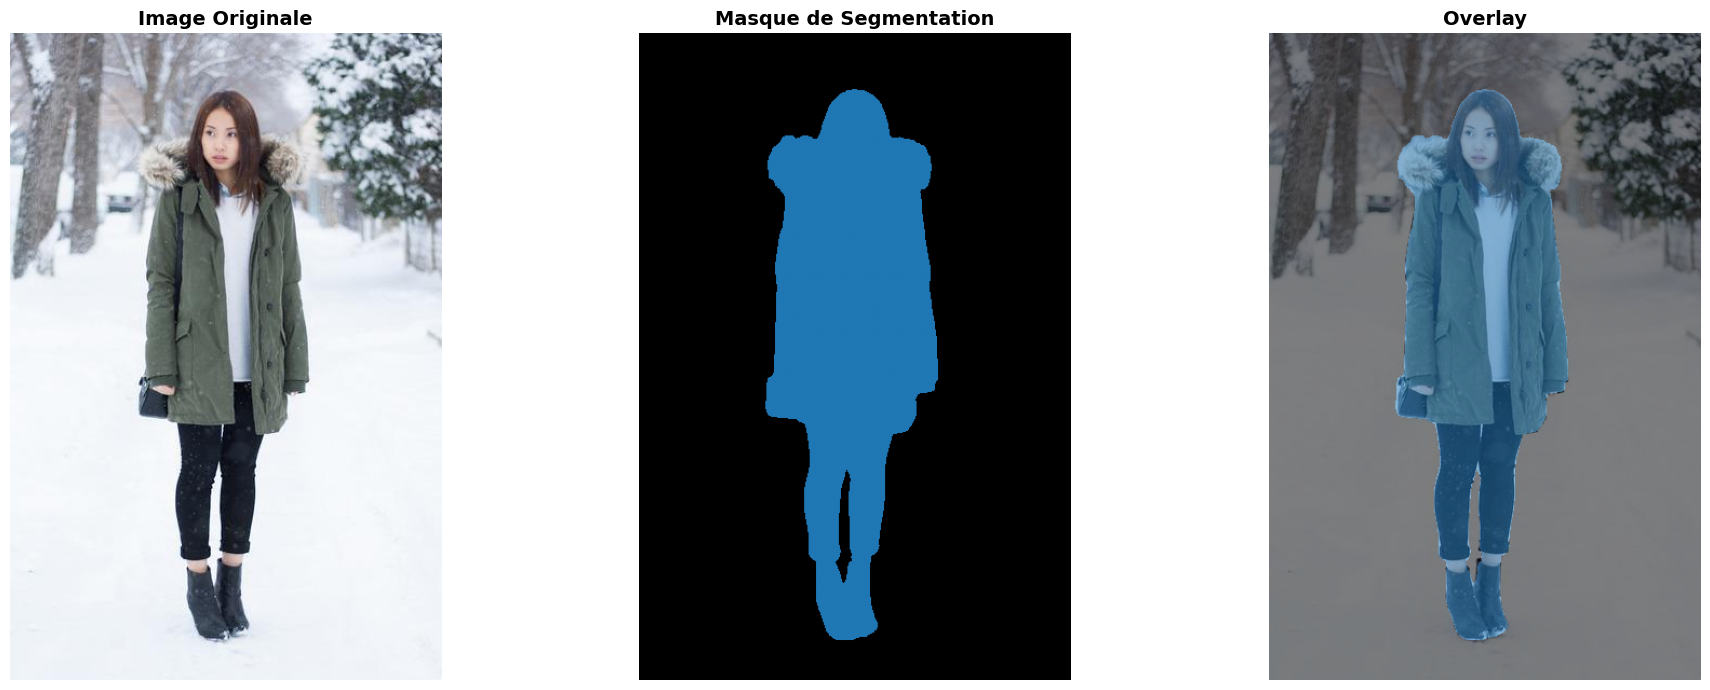


📊 Statistiques de segmentation:
------------------------------------------------------------

🖼️  Image 2/50: image_1.png
⏳ Envoi à l'API Hugging Face...
✅ Segmentation terminée!


KeyboardInterrupt: 

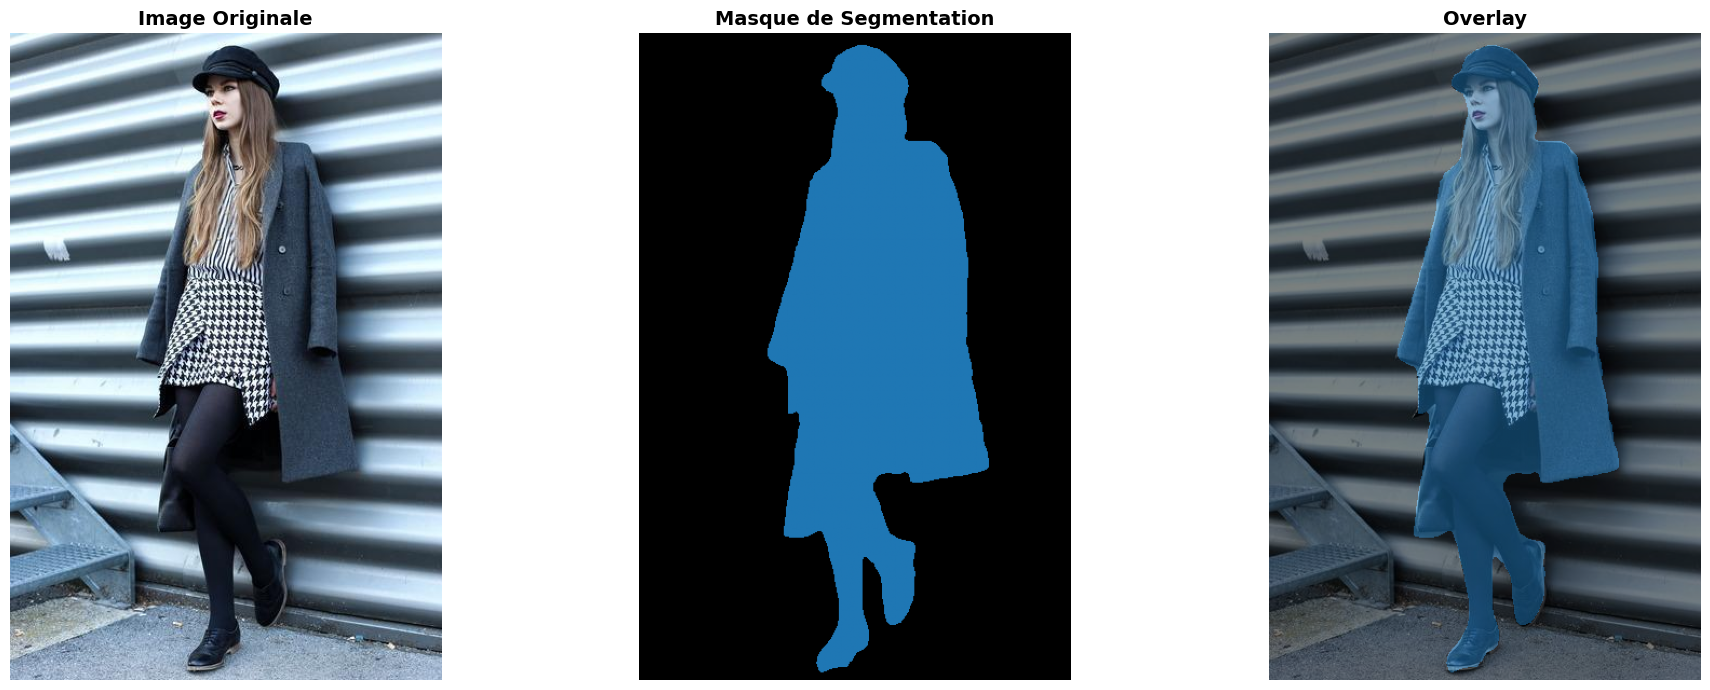

In [4]:
import requests
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from huggingface_hub import InferenceClient
import io
from dotenv import load_dotenv
load_dotenv()

class ClothesSegmentationAPI:
    """Client pour l'API de segmentation de vêtements"""
    
    def __init__(self, hf_token):
        os.environ["HF_TOKEN"] = hf_token
        self.client = InferenceClient(
            provider="hf-inference",
            api_key=hf_token
        )
        self.model = "sayeed99/segformer_b3_clothes"
        
        self.label_map = {
            0: "Background", 1: "Hat", 2: "Hair", 3: "Sunglasses",
            4: "Upper-clothes", 5: "Skirt", 6: "Pants", 7: "Dress",
            8: "Belt", 9: "Left-shoe", 10: "Right-shoe", 11: "Face",
            12: "Left-leg", 13: "Right-leg", 14: "Left-arm", 15: "Right-arm",
            16: "Bag", 17: "Scarf"
        }
        
        self.colors = plt.cm.tab20(np.linspace(0, 1, len(self.label_map)))
    
    def segment_image(self, image_path):
        output = self.client.image_segmentation(image_path, model=self.model)
        
        # Convertir le résultat en masque
        mask_image = output[0]['mask']  # Récupérer le masque
        return mask_image
    
    def visualize_results(self, image_path, mask, save_path=None):
        original = Image.open(image_path).convert('RGB')
        mask_array = np.array(mask)
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        
        axes[0].imshow(original)
        axes[0].set_title("Image Originale", fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        colored_mask = np.zeros((*mask_array.shape, 3))
        for label_id in np.unique(mask_array):
            if label_id < len(self.colors):
                colored_mask[mask_array == label_id] = self.colors[label_id][:3]
        
        axes[1].imshow(colored_mask)
        axes[1].set_title("Masque de Segmentation", fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        axes[2].imshow(original)
        axes[2].imshow(colored_mask, alpha=0.5)
        axes[2].set_title("Overlay", fontsize=14, fontweight='bold')
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✅ Résultat sauvegardé: {save_path}")
        
        plt.show()
        
        self._print_statistics(mask_array)
    
    def _print_statistics(self, mask_array):
        unique_labels = np.unique(mask_array)
        total_pixels = mask_array.size
        
        print("\n📊 Statistiques de segmentation:")
        print("-" * 60)
        
        for label_id in unique_labels:
            if label_id in self.label_map:
                count = np.sum(mask_array == label_id)
                percentage = (count / total_pixels) * 100
                label_name = self.label_map[label_id]
                
                if label_name != "Background" and percentage > 1:
                    print(f"  {label_name:15s}: {percentage:5.2f}% ({count:,} pixels)")

def find_images(folder_path):
    """
    Trouve toutes les images PNG dans un dossier
    """
    folder = Path(folder_path)
    
    if not folder.exists():
        print(f"❌ Le dossier '{folder_path}' n'existe pas!")
        return []
    
    # Trouver tous les fichiers .png (insensible à la casse)
    image_files = []
    
    for file in folder.iterdir():
        if file.is_file():
            # Vérifier l'extension en minuscules
            if file.suffix.lower() == '.png':
                image_files.append(file)
    
    return sorted(image_files)

def process_images_folder(folder_path, hf_token, save_results=False, max_images=None):

    folder = Path(folder_path)
    
    # Vérifier que le dossier existe
    if not folder.exists():
        print(f"❌ Erreur: Le dossier '{folder_path}' n'existe pas!")
        print(f"📁 Chemin absolu: {folder.absolute()}")
        return
    
    print(f"📂 Dossier analysé: {folder.absolute()}\n")
    
    # Initialiser l'API
    api = ClothesSegmentationAPI(hf_token)
    
    # Créer le dossier de résultats
    results_folder = None
    if save_results:
        results_folder = Path("segmentation_results")
        results_folder.mkdir(parents=True, exist_ok=True)
        print(f"📁 Dossier de résultats: {results_folder.absolute()}\n")
    
    # Trouver toutes les images PNG
    image_files = find_images(folder_path)
    
    print(f"🔍 {len(image_files)} image(s) PNG trouvée(s)\n")
    
    if len(image_files) == 0:
        print(f"⚠️ Aucune image PNG trouvée!")
        print(f"\n📂 Contenu du dossier:")
        for item in folder.iterdir():
            icon = "📁" if item.is_dir() else "📄"
            print(f"  {icon} {item.name}")
        return
    
    # Afficher les 5 premiers noms de fichiers
    print("📄 Exemples de fichiers trouvés:")
    for img in image_files[:5]:
        print(f"  • {img.name}")
    if len(image_files) > 5:
        print(f"  ... et {len(image_files) - 5} autre(s)\n")
    
    # Limiter le nombre d'images si demandé
    if max_images:
        image_files = image_files[:max_images]
        print(f"ℹ️  Traitement limité à {max_images} image(s)\n")
    
    # Traiter chaque image
    success_count = 0
    for idx, image_path in enumerate(image_files, 1):
        print(f"\n{'='*70}")
        print(f"🖼️  Image {idx}/{len(image_files)}: {image_path.name}")
        print(f"{'='*70}")
        
        try:
            print("⏳ Envoi à l'API Hugging Face...")
            mask = api.segment_image(str(image_path))
            print("✅ Segmentation terminée!")
            
            save_path = None
            if save_results and results_folder:
                save_path = results_folder / f"result_{image_path.stem}.png"
            
            api.visualize_results(str(image_path), mask, save_path)
            success_count += 1
            
        except Exception as e:
            print(f"❌ Erreur: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n{'='*70}")
    print(f"✅ Traitement terminé: {success_count}/{len(image_files)} image(s) traitée(s) avec succès")
    if save_results:
        print(f"📁 Résultats sauvegardés dans: {results_folder.absolute()}")
    print(f"{'='*70}")

# ============================================================================
# EXÉCUTION PRINCIPALE
# ============================================================================

# token API Hugging Face
HF_TOKEN = os.getenv("HF_TOKEN")
if not HF_TOKEN:
    raise ValueError("Le token HF_TOKEN n'a pas été trouvé dans le fichier .env")
    
# Chemin vers vos images
IMAGES_FOLDER = "data/images/IMG"

# Lancer l'analyse
print("🚀 Démarrage de l'analyse de segmentation de vêtements\n")
process_images_folder(
    folder_path=IMAGES_FOLDER,
    hf_token=HF_TOKEN,
    save_results=True  # Mettre False pour ne pas sauvegarder
)